### Preliminary steps.

In [1]:
# Supress Warnings.

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import important libraries.

import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib.pyplot import figure, show, subplot, yscale, plot, legend
import seaborn as sns
%matplotlib inline 

In [3]:
# # Jupyter Notebook will display all rows and columns this way. Use ctrl+/ to comment/un-comment.

# from IPython.display import display
# pd.options.display.max_rows = None
# pd.options.display.max_columns = None

In [4]:
# # Check the encoding of data. Use ctrl+/ to comment/un-comment.

# import chardet

# rawdata = open('loan.csv', 'rb').read()
# result = chardet.detect(rawdata)
# charenc = result['encoding']
# print(charenc)
# print(result) # It's utf-8 with 99% accuracy.

In [5]:
# Read csv data.

df = pd.read_csv('loan.csv', encoding='utf-8')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB
None


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [6]:
print(len(df.drop_duplicates().index) == len(df.index)) # Check for duplicate rows.
df.columns.nunique() == len(df.columns) # Check for duplicate columns.

True


True

Hence, no duplicate rows or columns.<br> <b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>
## 1. Data Cleaning
### Let's deal with null values.

In [7]:
# Calculate the column-wise null percentages.

null_per = round(df.isnull().sum(axis=0).sort_values(ascending=False)/len(df.index)*100, 2) # Null-percentages column-wise.
null_per[null_per>0] # Don't display column if it does't has any missing values.

total_il_high_credit_limit        100.00
mo_sin_old_rev_tl_op              100.00
bc_util                           100.00
bc_open_to_buy                    100.00
avg_cur_bal                       100.00
acc_open_past_24mths              100.00
inq_last_12m                      100.00
total_cu_tl                       100.00
inq_fi                            100.00
total_rev_hi_lim                  100.00
all_util                          100.00
max_bal_bc                        100.00
open_rv_24m                       100.00
open_rv_12m                       100.00
il_util                           100.00
total_bal_il                      100.00
mths_since_rcnt_il                100.00
open_il_24m                       100.00
open_il_12m                       100.00
open_il_6m                        100.00
open_acc_6m                       100.00
tot_cur_bal                       100.00
tot_coll_amt                      100.00
total_bc_limit                    100.00
dti_joint       

We can see that many columns are <b>completely empty</b>. It's safe to delete those columns then.<br>Generally columns are deleted if they have more than 5% missing values. Here we can see that `emp_title` has border-line missing value ~6%. On closer look at the values of this column, we can say that it will not help us in prediction task. Thus we can delete `emp_title`.

In [8]:
# Remove columns with more than 5% missing values.

df = df[df.columns[df.isnull().mean() < 0.05]] # This step also deletes the `emp_title` column.
len(df.columns) # 52 columns of original 111 retained.

52

In [9]:
# Now, remove rows with null values.

df.dropna(axis=0, inplace=True)
print(len(df.index)/39717*100) # 95% rows retained.
null_per = round(df.isnull().sum(axis=0).sort_values(ascending=False)/len(df.index)*100, 2) # Null-percentages column-wise.
null_per[null_per>0] # Don't display column if it doesn't has any missing values.

95.23126117279755


Series([], dtype: float64)

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>
### Let's drop some more columns.
Create a column dictionary with keys as their data-types.

In [10]:
grp = df.columns.to_series().groupby(df.dtypes).groups
col_dict = {key.name: value for key, value in grp.items()}
col_dict['object'] # Output of < type(col_dict['object']) > will be pandas.core.indexes.base.Index

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type'],
      dtype='object')

-  Let's look at columns with data-type `object` first. Some numerical variables may have been parsed here as type `object` because of missing values in the dataset in that column or some other reasons.

In [11]:
df.loc[:, col_dict['object']].head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,36 months,10.65%,B,B2,10+ years,RENT,Verified,Dec-11,Fully Paid,n,...,credit_card,Computer,860xx,AZ,Jan-85,83.70%,f,Jan-15,May-16,INDIVIDUAL
1,60 months,15.27%,C,C4,< 1 year,RENT,Source Verified,Dec-11,Charged Off,n,...,car,bike,309xx,GA,Apr-99,9.40%,f,Apr-13,Sep-13,INDIVIDUAL
2,36 months,15.96%,C,C5,10+ years,RENT,Not Verified,Dec-11,Fully Paid,n,...,small_business,real estate business,606xx,IL,Nov-01,98.50%,f,Jun-14,May-16,INDIVIDUAL
3,36 months,13.49%,C,C1,10+ years,RENT,Source Verified,Dec-11,Fully Paid,n,...,other,personel,917xx,CA,Feb-96,21%,f,Jan-15,Apr-16,INDIVIDUAL
4,60 months,12.69%,B,B5,1 year,RENT,Source Verified,Dec-11,Current,n,...,other,Personal,972xx,OR,Jan-96,53.90%,f,May-16,May-16,INDIVIDUAL


`term` and `emp_length` are categorical right now. As of now, i don't know if they should be converted to numerical type to better suit our analysis. `revol_until` and `int_rate` should be of `numerical` data-type. We also have some date-type columns stored as `object` data-type. Will deal with this later.

In [12]:
# Changing to numerical data-type.

df['revol_util'] = df['revol_util'].astype(str).str.split(pat='%').map(lambda x:x[0]).astype('float')
df['int_rate'] = df['int_rate'].astype(str).str.split(pat='%').map(lambda x:x[0]).astype('float')
df[['revol_util', 'int_rate']].head()

,revol_util,int_rate
0,83.7,10.65
1,9.4,15.27
2,98.5,15.96
3,21.0,13.49
4,53.9,12.69


In [13]:
# # Use ctrl+/ to comment/un-comment. Comment/un-comment columns one-by-one, execute, and see the values.

# df.application_type.value_counts() # All are INDIVIDUAL. So, better delete this column.
# df.url # url column should be deleted. Won't help in understanding risk.
# df.pymnt_plan.value_counts() # All are n. So, better delete this column.
# df.initial_list_status.value_counts() # All are f. So, better to delete this column.
# df.title.value_counts() # There are a lot of categories for reason of the loan. On closer scrutiny, it can be said that
# # we can delete this column.
# df.loan_status.value_counts() # 3 categories. Fully Paid, Charged Off and Current.
# df.verification_status.value_counts() # 3 Categories. Not Verified, Verified and Source Verified.
# df.home_ownership.value_counts() # 5 categories. RENT, MORTGAGE, OWN, OTHER and NONE.
# df.emp_length.value_counts() # 10 categories. 1 and less than 1 yr, 2, 3, 4, ...., 9, 10 and more than 10 years.
# df.grade.value_counts(),df.sub_grade.value_counts() # Grades:A to G, Sub-grade: 5 levels (1 to 5).
# df.purpose.value_counts() # This stores various reasons for loan. Will help us to do segmented analysis, just like other categorical variables above.
# df.zip_code.value_counts() # We have quiet a lot of zip-codes. Will have to dig into deeper, because zip-codes are 
# # important variables for risk analytics. Found this information when doing some online reading.

In [14]:
# Drop the identfied columns.

df.drop(['application_type', 'url', 'pymnt_plan', 'initial_list_status', 'title'], axis=1, inplace=True)
len(df.columns) # 47 columns of original of 111 retained.

47

-  Let's look at columns with data-type `int` and `float`, i.e., numerical values. We suspect columns like phone number or other unnecessary columns might be here.

In [15]:
col_dict['int64'] 

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'policy_code', 'acc_now_delinq', 'delinq_amnt'],
      dtype='object')

In [16]:
# # Use ctrl+/ to comment/un-comment. Comment/un-comment columns one-by-one, execute, and see the values.

# df.acc_now_delinq.value_counts() # All are 0. Better to delete this column.
# df.delinq_amnt.value_counts() # All are 0. Better to delete this column.
# df.policy_code.value_counts() # All are 1. Better to delete this column.
# df.delinq_2yrs.value_counts() # Values range from 0,1,2,....,10,11.
# df.inq_last_6mths.value_counts() # Values range from 0,1,2,....,7,8.
# df.open_acc.value_counts() # Values range from 2,3,....,43,44.
# df.pub_rec.value_counts() # Values range from 0,1,..,4.

`id` and `member_id` can be deleted as well.

In [17]:
# Drop the identfied columns.

df.drop(['id', 'member_id', 'acc_now_delinq', 'policy_code', 'delinq_amnt'], axis=1, inplace=True)
len(df.columns) # 42 columns of original of 111 retained.

42

In [18]:
col_dict['float64']

Index(['funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'chargeoff_within_12_mths',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [19]:
# # Use ctrl+/ to comment/un-comment. Comment/un-comment columns one-by-one, execute, and see the values.

# df.collections_12_mths_ex_med.value_counts() # All are 0.0. So, better delete this column.
# df.chargeoff_within_12_mths.value_counts() # All are 0.0. So, better to delete this column.
# df.tax_liens.value_counts() # All are 0.0. So, better to delete this column.
# df.pub_rec_bankruptcies.value_counts() # Has 3 values. 0, 1 and 2.

`funded_amnt_inv`, `installment`, `annual_inc`, `dti`, `out_prncp`, `out_prncp_inv`, `total_pymnt`, `total_pymnt_inv`, `total_rec_prncp`, `total_rec_int`, `total_rec_late_fee`, `recoveries`, `collection_recovery_fee`, `last_pymnt_amnt` - All these columns store amount of money.

In [20]:
# Drop the identfied columns.

df.drop(['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens'], axis=1, inplace=True)
len(df.columns) # 39 columns of original of 111 retained.

39

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>
On reading the data dictionary and other literature avaiable, we can drop some columns which do not seem to contribute as a factor for 'defaulting' of loan.<br>
These columns are as mentioned:
`funded_amnt_inv` , `out_prncp`, `out_prncp_inv`, `total_pymnt_inv`, `total_rec_prncp`, `total_rec_int`,
`total_rec_late_fee`, `recoveries`, `collection_recovery_fee`.

In [21]:
# Drop the identfied columns.

df.drop([ 'funded_amnt_inv' , 'out_prncp', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee'], axis=1, inplace=True)
df.head() # 30 columns of original 111 retained.

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,...,3,0,13648,83.7,9,5863.155187,Jan-15,171.62,May-16,0.0
1,2500,2500,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,...,3,0,1687,9.4,4,1008.710000,Apr-13,119.66,Sep-13,0.0
2,2400,2400,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,...,2,0,2956,98.5,10,3005.666844,Jun-14,649.91,May-16,0.0
3,10000,10000,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,...,10,0,5598,21.0,37,12231.890000,Jan-15,357.48,Apr-16,0.0
4,3000,3000,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,...,15,0,27783,53.9,38,3513.330000,May-16,67.79,May-16,0.0


We can see that we have 4 `date` columns (3 are those who have `_d` in the end of their name and column `earliest_cr_line`) which are of `object` type right now. We can convert them to `date`. (`next_pymnt_d` was deleted earlier because it had a lot of missing values.)

In [22]:
df[['issue_d', 'earliest_cr_line','last_pymnt_d', 'last_credit_pull_d']].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,Dec-11,Jan-85,Jan-15,May-16
1,Dec-11,Apr-99,Apr-13,Sep-13
2,Dec-11,Nov-01,Jun-14,May-16
3,Dec-11,Feb-96,Jan-15,Apr-16
4,Dec-11,Jan-96,May-16,May-16


In [23]:
# Converting data-type to date.

df['issue_d'] = pd.to_datetime(df['issue_d'],format='%b-%y',dayfirst = True)
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'],format='%b-%y',dayfirst = True)
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'],format='%b-%y',dayfirst = True)
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'],format='%b-%y',dayfirst = True)

df[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2011-12-01,1985-01-01,2015-01-01,2016-05-01
1,2011-12-01,1999-04-01,2013-04-01,2013-09-01
2,2011-12-01,2001-11-01,2014-06-01,2016-05-01
3,2011-12-01,1996-02-01,2015-01-01,2016-04-01
4,2011-12-01,1996-01-01,2016-05-01,2016-05-01


<font color=red>Note: <i>All the datetime values show date of the month as 1. This is not true. This is happening because, we only had month and year information originally.</i></font>

In [24]:
# Take a look at all the unique year values in all the date columns.

(df.issue_d.map(lambda x: x.year).value_counts(), 
df.earliest_cr_line.map(lambda x: x.year).value_counts(), 
df.last_pymnt_d.map(lambda x: x.year).value_counts(), 
df.last_credit_pull_d.map(lambda x: x.year).value_counts())

(2011    20857
 2010    11170
 2009     4687
 2008     1104
 2007        5
 Name: issue_d, dtype: int64, 2000    3121
 1999    2868
 1998    2741
 2001    2438
 1997    2354
 1996    2183
 1995    2054
 1994    1932
 2002    1848
 2003    1787
 2004    1696
 2005    1444
 1993    1439
 2006    1119
 1992    1008
 1990     979
 1991     927
 1989     813
 1988     699
 2007     685
 1987     593
 1986     468
 1985     429
 1984     375
 1983     316
 1982     202
 1981     164
 1980     162
 2008     149
 1979     145
 1978     140
 1977     101
 1976      77
 1975      66
 1974      55
 1973      47
 1971      39
 1972      38
 1970      37
 1969      26
 2067      15
 2068      14
 2066       8
 2065       7
 2063       4
 2064       4
 2062       3
 2046       1
 2056       1
 2054       1
 2050       1
 Name: earliest_cr_line, dtype: int64, 2013    9162
 2014    8925
 2012    8691
 2011    4636
 2015    2377
 2016    1976
 2010    1586
 2009     426
 2008      44
 Name: last_pymnt_

It is to be noticed that, the date is set as first day of the month. Although, this is not correct. It won't really matter because months or years might show some pattern in defaulting, etc., though the chances of even that seem bleak.<br> <font color=red>`earliest_cr_line` has year above 2050. Will need to rectify.</font>

In [25]:
# Rectifying years above 2046.

df.loc[df.earliest_cr_line.dt.year>=2046,'earliest_cr_line']=df.earliest_cr_line-pd.DateOffset(years=100)

In [26]:
df.columns # All the retained columns.

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>
### Outlier detection.
Outliers will only be detected for numerical variables.

In [27]:
# We need to create the dictionary again, as we had deleted some columns, as well as changed data-types.

grp = df.columns.to_series().groupby(df.dtypes).groups
col_dict = {key.name: value for key, value in grp.items()}

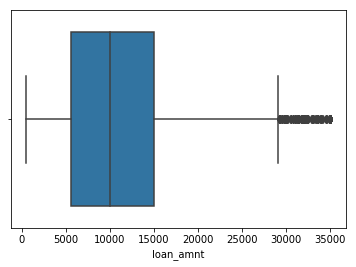

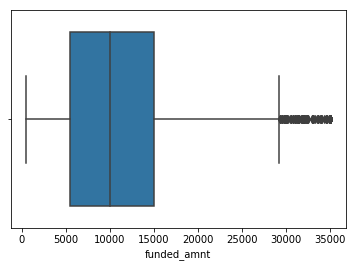

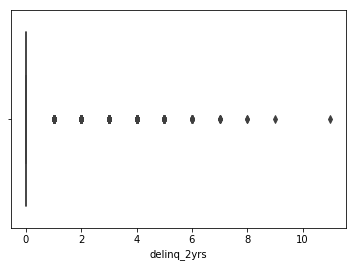

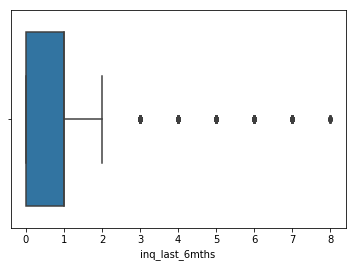

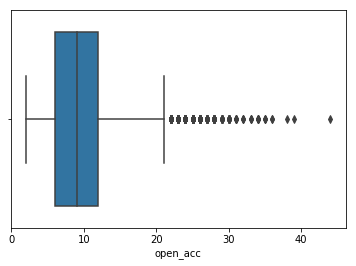

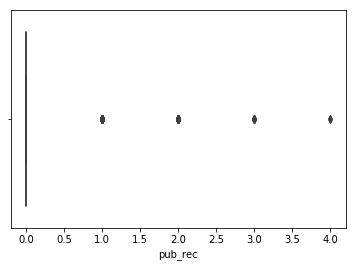

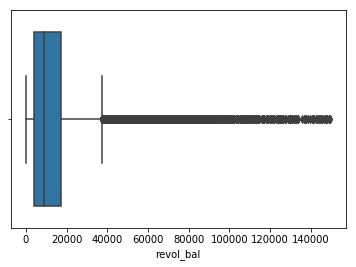

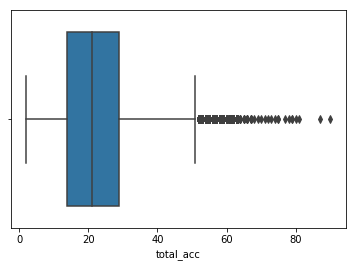

In [28]:
# Plotting all the integer-type columns.

int_col = col_dict['int64']
i = 1
for col in int_col:
    figure(i)
    sns.boxplot(col, data=df)
    i = i+1
show()

- loan_amnt - Box plot suggests values from \\$30,000 to \\$35,000 as outlier. But this value is OK for asking a loan.
- funded_amnt - Same case as loan_amnt. This column does not have any outliers.
- delinq_2yrs - <i>The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.(Definition picked up from data dictionary.)</i> This is rather a <b>categorical</b> variable. It has distinct values. 0,1,2,... upto 11.
- inq_last_6mnths - This too is a <b>categorical</b> variable.
- open_acc - Again, <b>categorical</b>....
- pub_rec - Again, <b>categorical</b>....
- revol_bal - Googled it - <i>In credit card terms, a revolving balance is the portion of credit card spending that goes unpaid at the end of a billing cycle</i>. Will have to look it in log-scale, since the range of values are very big. 
- total_acc - <i>The total number of credit lines currently in the borrower's credit file.(Definition picked up from data dictionary.)</i>

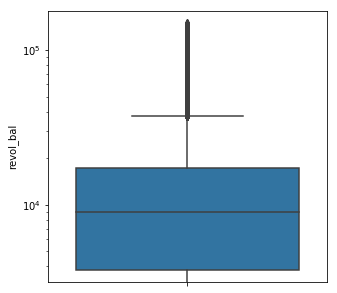

In [29]:
# Plotting column 'revol_util' in log-scale.

figure(figsize=(5,5))
yscale('log')
sns.boxplot(y='revol_bal', data=df)
show()

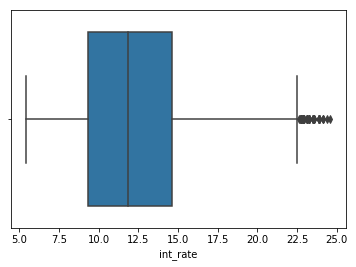

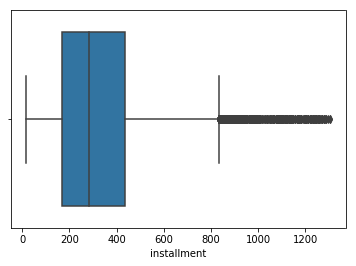

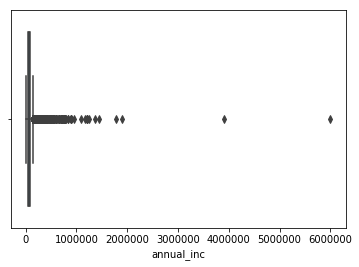

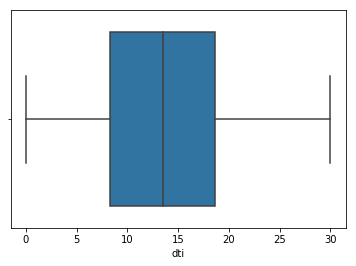

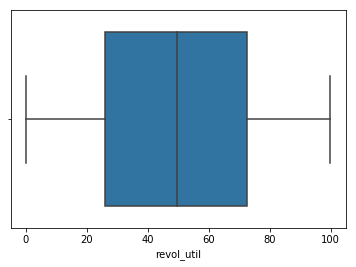

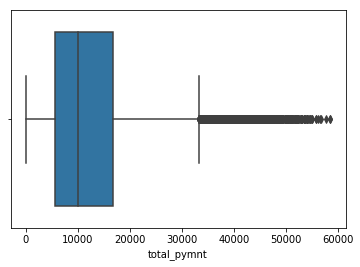

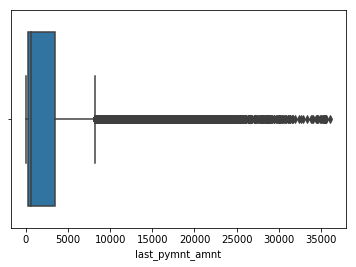

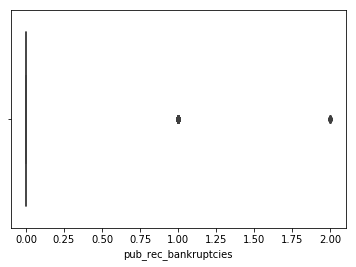

In [30]:
# Plotting all the float-type columns.

float_col = col_dict['float64']
i = 1
for col in float_col:
    figure(i)
    sns.boxplot(col, data=df)
    i = i+1
show()

- int_rate - No abnormal values seem to be present.
- installment - The values that are suggested as outliers, aren't really outliers. This is the monthly installment for a loan.
- annual_inc - This has some high variation, and it also has outliers like <b>4 and 6 million dollars</b></font>. Will have to look this up in log-scale.
- dti - A low debt-to-income ratio will be favourable.<b> It should be noticed that, the numbers here are in percentage</b>.
- revol_util - <b> It should be noticed that, the numbers here are in percentage</b></font>.
- last_pymnt_amnt - Will have to look this up in log-scale.
- pub_rec_bankruptcies - This is rather a <b>categorical</b> variable. Lower is better.

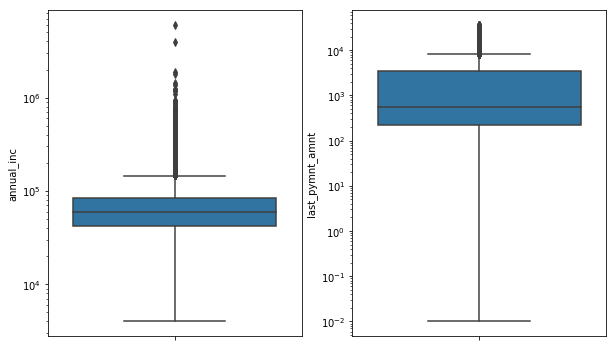

In [31]:
figure(figsize=(10,6))
subplot(121)
yscale('log')
sns.boxplot(y='annual_inc', data=df)
subplot(122)
yscale('log')
sns.boxplot(y='last_pymnt_amnt', data=df)
show()

It's safe to assume that people with high annual income will not default. We will check this later.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>
## 2. Analysis
### Univariate/Bivariate/Segmented.

In [32]:
pd.set_option('display.precision', 2) # Will only show values till 2-decimal places.
df.describe(percentiles=[.5]) # Statistical snapshot of numerical data.

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,last_pymnt_amnt,pub_rec_bankruptcies
count,37823.00,37823.00,37823.00,37823.00,3.78e+04,37823.00,37823.00,37823.00,37823.00,37823.00,37823.00,37823.00,37823.00,37823.00,37823.00,37823.00
mean,11328.89,11051.00,12.07,327.16,6.97e+04,13.38,0.15,0.87,9.33,0.05,13482.78,49.13,22.20,12311.77,2731.02,0.04
std,7477.32,7205.15,3.73,209.10,6.37e+04,6.66,0.49,1.07,4.38,0.23,15878.86,28.28,11.38,9083.54,4490.08,0.20
min,500.00,500.00,5.42,16.08,4.00e+03,0.00,0.00,0.00,2.00,0.00,0.00,0.00,2.00,33.73,0.01,0.00
50%,10000.00,10000.00,11.86,283.20,6.00e+04,13.47,0.00,1.00,9.00,0.00,8981.00,49.70,21.00,10074.70,563.55,0.00
max,35000.00,35000.00,24.59,1305.19,6.00e+06,29.99,11.00,8.00,44.00,4.00,149588.00,99.90,90.00,58563.68,36115.20,2.00


In [33]:
# Creating a new column that records profit.

df['Profit_%'] = (df['total_pymnt'] - df['funded_amnt'])*100 / df['funded_amnt']

`loan_status` column contains the final status of the Loan - Fully Paid (cleared the loan), Current (paying installments currently, and on time as well) and Charged Off (did not pay timely installment). Plotting frequencies of different Loan Statuses using countplot to have a sense of their relative occurence.

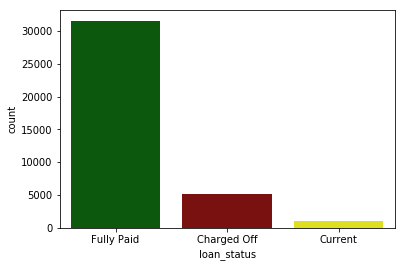

In [34]:
palette = {'Fully Paid':'DarkGreen', 'Charged Off':'DarkRed', 'Current':'Yellow'} # Colour palette to be used in graphs.
loan_status_overall = sns.countplot(x="loan_status", data=df, palette=palette)

In [35]:
df['loan_status'].value_counts() # Number of occurences of each status.

Fully Paid     31524
Charged Off     5201
Current         1098
Name: loan_status, dtype: int64

It is visible that about <b>5200</b> accounts defaulted. Thus, around <b>14%</b> accounts have defaulted. (Charged Off/(Charged Off+Fully Paid) ~ 5201/(5201+31524) ~ 14.16%)
<br>Now let us see the distribution of `loan_amnt` w.r.t to 'Fully Paid' and 'Charged Off' statuses to find whether loan amount has any bearing on <b>defaulting behaviour</b>.

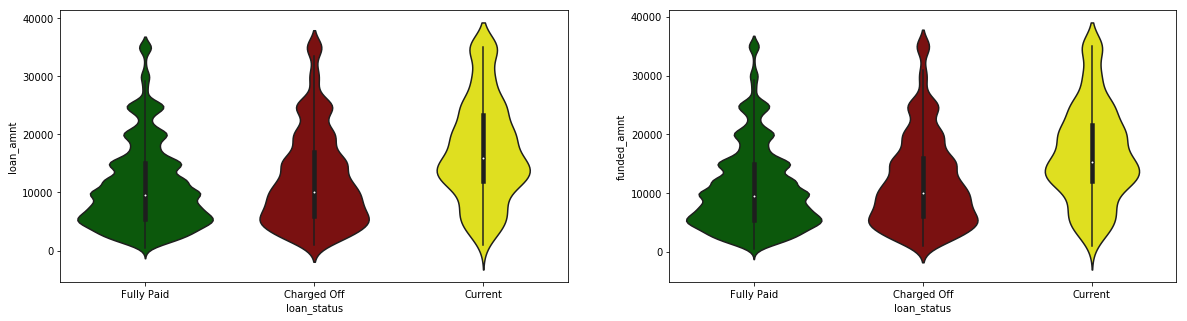

In [36]:
figure(figsize=(20,5))
subplot(121)
sns.violinplot(x="loan_status", y="loan_amnt", data=df, palette=palette) # loan amount vs. status, violinplot.
subplot(122)
sns.violinplot(x="loan_status", y="funded_amnt", data=df, palette=palette) # loan amount vs. status, violinplot.

As there is similar distribution between 'Fully Paid' and 'Charged Off' status, we conclude that loan amount doesn't impact <b>defaulting behavior</b>. Similar pattern is seen for `funded_amnt` and `loan_status`. This was expected.
<br> Now let us see the distribution of `grade` segmented by `loan_status`.

loan_status  Charged Off  Current  Fully Paid  Default_%
grade                                                   
A                    546       35        8965       5.72
B                   1313      327        9820      11.46
C                   1228      257        6222      15.93
D                   1036      216        3799      20.51
E                    678      175        1888      24.74
F                    304       71         634      30.13
G                     96       17         196      31.07


Text(0, 0.5, 'Percentage')

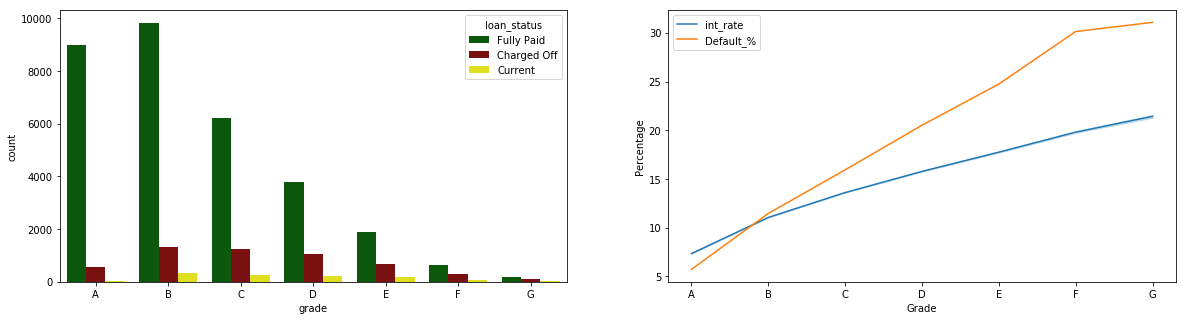

In [37]:
# Plotting against 'grade'.

# Groupby, status of the loan and grade.
loan_status_by_grade = df.groupby(['loan_status', 'grade']).size().reset_index().pivot(columns='loan_status', index='grade', values=0)
# Percent of people that have defaulted.
loan_status_by_grade['Default_%'] = loan_status_by_grade['Charged Off']*100/(loan_status_by_grade['Current']+loan_status_by_grade['Charged Off']+loan_status_by_grade['Fully Paid'])
print(loan_status_by_grade)

figure(figsize=(20,5))
subplot(121)
order = ['A','B','C','D','E','F','G'] # Order in which x-tick marks will be displayed in the graph.
sns.countplot(x='grade', data=df, hue='loan_status', palette=palette, order=order) # Plot 1, on the left.
subplot(122)
sns.lineplot(x='grade', y='int_rate', data=df, style_order=order) # Plot 2, on the right.
sns.lineplot(x=loan_status_by_grade.index, y='Default_%', data=loan_status_by_grade)  # Plot 2, on the right.

legend(['int_rate', 'Default_%'], loc='upper left')
plt.pyplot.xlabel('Grade')
plt.pyplot.ylabel('Percentage')

So, percentage-wise more loans are getting defaulted in Grades <font color=red><b>C,D,E,F and G</b></font> as compared to grades <font color=red><b>A and B </b></font>. <u>Thus, grade of a loan can give a signal of default. We can also see that interest rate increases as the grade changes from A to G, and the default percentafe increases as well</u>. Thus interest rate should also be correlated with <b>defaulting behaviour</b>.
<br>Let us see grades with more granularity.

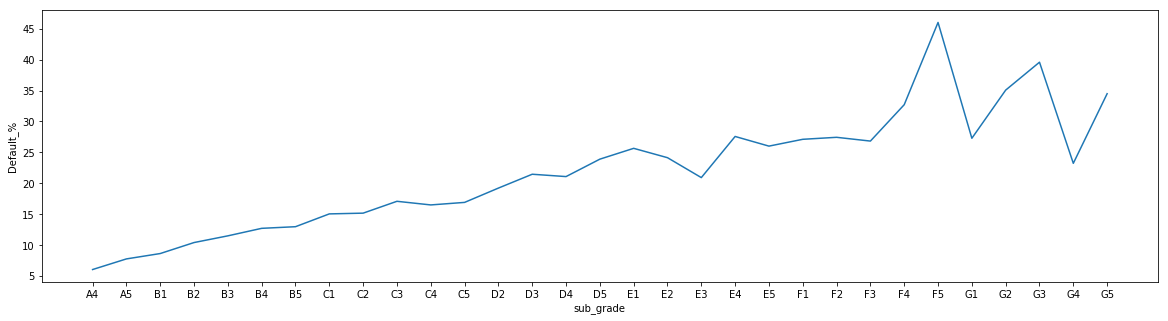

In [38]:
# Plotting against 'sub_grade'.

# Groupby, status of the loan and grade.
loan_status_by_sub_grd = df.groupby(['loan_status', 'sub_grade']).size().reset_index().pivot(columns='loan_status', index='sub_grade', values=0)
# Percent of people that have defaulted.
loan_status_by_sub_grd['Default_%'] = loan_status_by_sub_grd['Charged Off']*100/(loan_status_by_sub_grd['Current']+loan_status_by_sub_grd['Charged Off']+loan_status_by_sub_grd['Fully Paid'])
# print(loan_status_by_sub_grd)

figure(figsize=(20,5))
# Order in which x-tick marks will be displayed in the graph.
order = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2','C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4','E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']
sns.lineplot(x=loan_status_by_sub_grd.index, y=loan_status_by_sub_grd['Default_%'], style_order=order)

As the grade increases from A towards G, default percentage increases. This was expected.

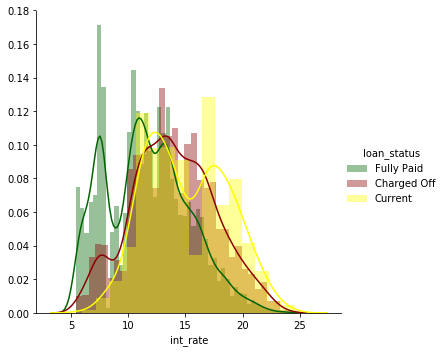

In [39]:
# Plot the interest rate vs. status of the loan.

g = sns.FacetGrid(df, hue="loan_status", height=5, palette=palette)
g = g.map(sns.distplot, "int_rate").add_legend()

Observe the <font color=green>green line</font> and the <font color=red>red line</font>. On the left side of the graph(where `int_rate` is low), the green line is above the red line. It means that for lower interset rates, larger share of people have 'Fully Paid' status rather than 'Charged Off' status. On the right side of the graph, opposite pattern is seen. <u>Thus, our understanding of interest rate and defaulting behaviour stands true</u>.<br> 'Employment Length' can be an important signal whether person will Default or not, so can be 'Home Ownership Status'. Let us see the distribution of `loan_status` for these variables.

In [40]:
# This function returns the employee experience.

entry_level = ['< 1 year','1 year','2 years','3 years']
mid_level = ['4 years','5 years','6 years','7 years']
high_level = ['8 years','9 years','10+ years']

def emp_exp(year):
    if year in entry_level:
        return 'Novice Exp' # Work experience: Fresher to 3 years.
    elif year in mid_level:
        return 'Mid Exp' # Work experience: 3 to 7 years.
    else:
        return 'High Exp' # Work experience: 8 years and above.

df['emp_length_category'] = df['emp_length'].map(lambda x: emp_exp(x)) # Creating a new column.

emp_length_category,High Exp,Mid Exp,Novice Exp,Novice_Grade_%
grade,,,,
A,3005,2641,3900,69.08
B,3428,3180,4852,73.43
C,2184,2138,3385,78.32
D,1491,1437,2123,72.51
E,884,771,1086,65.62
F,337,292,380,60.41
G,106,87,116,60.10


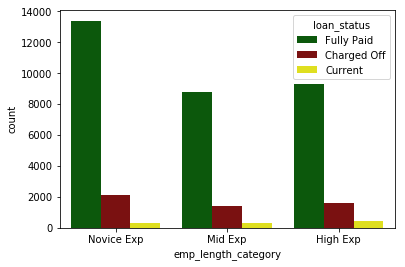

In [41]:
# Plotting against 'emp_length_category'.

order = ['Novice Exp', 'Mid Exp', 'High Exp']
sns.countplot(x='emp_length_category', hue='loan_status', data=df, order=order, palette=palette)

emp_exp_by_grade = df.groupby(['emp_length_category', 'grade']).size().reset_index().pivot(columns='emp_length_category', index='grade', values=0)
# The column created below records the percentage of people with novice work experience.
emp_exp_by_grade['Novice_Grade_%'] = emp_exp_by_grade['Novice Exp']*100/(emp_exp_by_grade['Mid Exp']+emp_exp_by_grade['High Exp'])
emp_exp_by_grade

<font color=red><b>Countplot suggests that, people who have just begun their carrer show lesser chance of defaulting</b></font>. The reason for this seems that better grade loans like A,B and C (which have lower interest rates) are more likely to be given to novices and lower grade loans (with higher interest rates) like D,E,F and G are less likely to be given to novices. And it had been established above that lower grades are more likely to <b>default</b>.

loan_status     Charged Off  Current  Fully Paid  Default_%
home_ownership                                             
MORTGAGE             2182.0    617.0     14134.0      12.89
OTHER                  18.0      NaN        78.0      18.75
OWN                   382.0     71.0      2315.0      13.80
RENT                 2619.0    410.0     14997.0      14.53


E:\Users\ASHISH\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


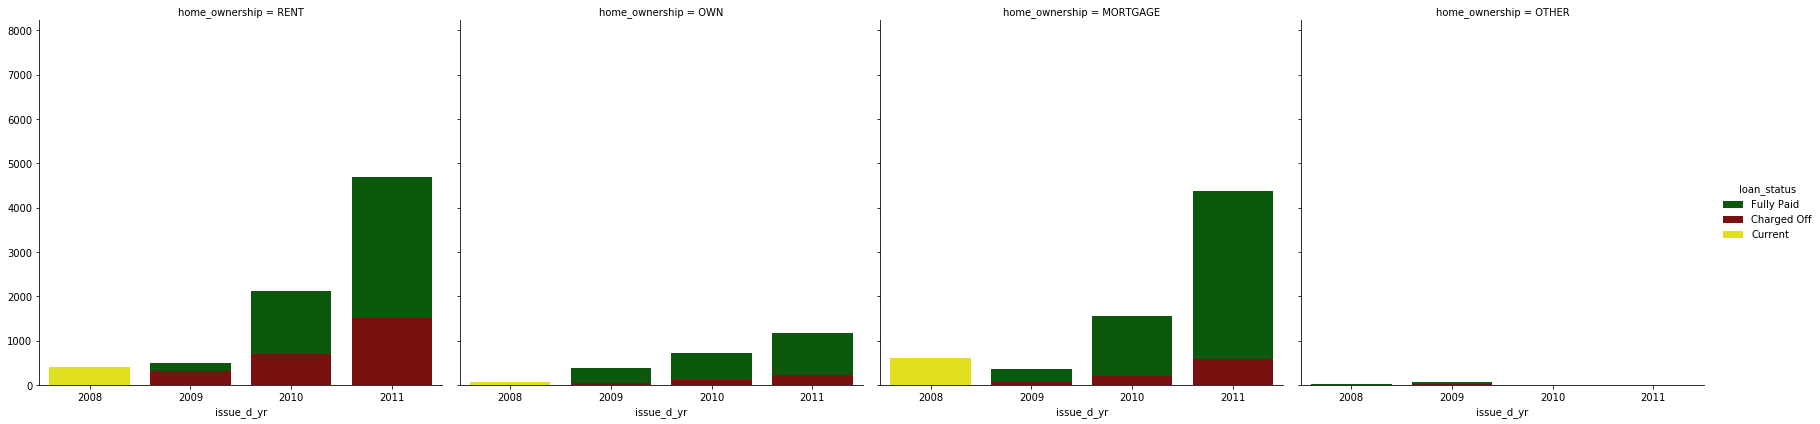

In [42]:
df['issue_d_yr'] = df['issue_d'].map(lambda x: x.year) # Creating a new column that records only year of the issue date.

# Printing table against 'Home Ownership' Status.

loan_status_by_home = df.groupby(['loan_status', 'home_ownership']).size().reset_index().pivot(columns='loan_status', index='home_ownership', values=0)
loan_status_by_home['Default_%'] = loan_status_by_home['Charged Off']*100/(loan_status_by_home['Current'].add(loan_status_by_home['Charged Off'],fill_value=0)+loan_status_by_home['Fully Paid'])
print(loan_status_by_home)

# Plotting against 'Home Ownership' and segment by year.

g = sns.FacetGrid(df, col='home_ownership', hue='loan_status', palette=palette, height=6)
g.map(sns.countplot, 'issue_d_yr').add_legend()

It can be seen that 'Other' category has the highest default rate when `home_ownership` vs. `loan_status` is compared. <font color=red><b>But on segmenting by year, it can be seen on the countplot that as the year progresses, percentage-wise, Mortgage owners are less likely to default than people who Rent </b><i>(Note:We are not comparing with the category 'Other' because of it's sparsity)</i></font>. This might be because after the housing bubble burst in 2008, mortgage was given to people only after stringent scrutiny. Thus the people who were qualified for mortgage, were less likely to default on another loan as well, as they had already been thoroughly verified in their mortgage process and considered fit for giving loans.
<br> Now let us see the distribution of Annual Income w.r.t to 'Fully Paid' and 'Charged Off' status to find whether loan amount has any bearing on <b>'defaulting behaviour'.</b>
<br>We identified above that `annual_inc` has big outliers. Let us plot this figure but without considering the annual income outliers to get better picture. Using standard deviation concept (ignoring values beyond 2*S.D).

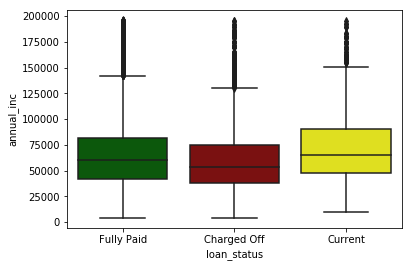

In [43]:
sns.boxplot(x="loan_status", y="annual_inc",data=df[np.abs(df.annual_inc-df.annual_inc.mean()) <= (2*df.annual_inc.std())], palette=palette)

The general intuition would be that people with higher annual income will not default. That isn't the case here. People with high annual income are amply visible in 'Charged Off' status. (<i>We can see that the median line of 'Fully Paid' is above the median line of 'Charged Off', but only <b>slightly</b> above.</i>). So, we conclude that `annual_inc` does not decide <b>defaulting behaviour</b>.

In [44]:
# This function returns the applicant's Salary range.

def sal_range(salary):
    if salary in range(0,20000):
        return '< 20'
    elif salary in range(20000,40000):
        return '20 to 40'
    elif salary in range(40000,60000):
        return '40 to 60'
    elif salary in range(60000,80000):
        return '60 to 80'
    else:
        return '> 80'
    
df['annual_inc_range'] = df['annual_inc'].apply(lambda x: sal_range(x)) # Creating new column.    

loan_status,Charged Off,Current,Fully Paid,Default_%
annual_inc_range,,,,
20 to 40,1204,131,5862,16.73
40 to 60,1509,307,8555,14.55
60 to 80,1108,246,6944,13.35
< 20,163,5,671,19.43
> 80,1217,409,9492,10.95


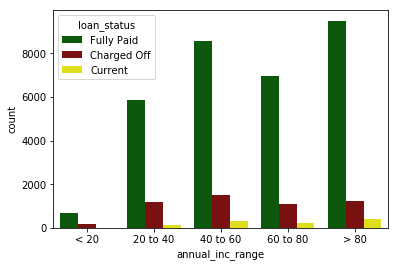

In [45]:
# Plotting against 'emp_length_category'.

order = ['< 20', '20 to 40', '40 to 60', '60 to 80', '> 80']
sns.countplot(x='annual_inc_range', hue='loan_status', data=df, order=order, palette=palette)

loan_stat_by_inc_range = df.groupby(['loan_status', 'annual_inc_range']).size().reset_index().pivot(columns='loan_status', index='annual_inc_range', values=0)
loan_stat_by_inc_range['Default_%'] = loan_stat_by_inc_range['Charged Off']*100/(loan_stat_by_inc_range['Current']+loan_stat_by_inc_range['Charged Off']+loan_stat_by_inc_range['Fully Paid'])
loan_stat_by_inc_range

On just comparing `loan status` and `annual_inc`, no major pattern is seen.<font color=red><b> But when we create buckets of `annual_inc` and further analyze, it can be seen that as the salary range increases, less percentage of people default. We should be more careful when providing loan to people with salary less than 20,000 dollars.</b></font><br> Let us see the relationship between `verification_status` and `loan_status`.

Text(0, 0.5, 'Percentage')

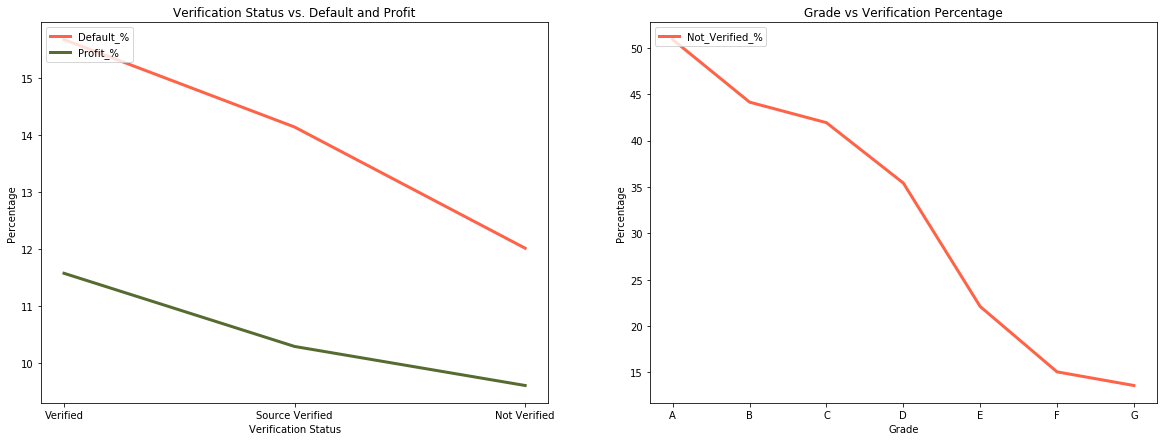

In [46]:
# Creating dataframes for plotting.

loan_status_by_veri = df.groupby(['loan_status', 'verification_status']).size().reset_index().pivot(columns='loan_status', index='verification_status', values=0)
veri_stat_profit = pd.DataFrame(df.groupby('verification_status')['Profit_%'].mean().sort_values())
loan_status_by_veri['Default_%'] = loan_status_by_veri['Charged Off']*100/(loan_status_by_veri['Current']+loan_status_by_veri['Charged Off']+loan_status_by_veri['Fully Paid'])
loan_status_by_veri = loan_status_by_veri.merge(veri_stat_profit, how='outer', left_index=True, right_index=True)
loan_status_by_veri.sort_values(by=['Default_%', 'Profit_%'], ascending=False, inplace=True)

figure(figsize=(20,7))
subplot(121)
plt.pyplot.title('Verification Status vs. Default and Profit')
plot(loan_status_by_veri['Default_%'], 'tomato', label='Default_%', linewidth=3.0)
plot(loan_status_by_veri['Profit_%'], 'darkolivegreen', label='Profit_%', linewidth=3.0)
legend(loc='upper left')
plt.pyplot.xlabel('Verification Status')
plt.pyplot.ylabel('Percentage')

subplot(122)
ver_stat_by_grade = df.groupby(['verification_status', 'grade']).size().reset_index().pivot(columns='verification_status', index='grade', values=0)
ver_stat_by_grade['Not_Verified_%'] = ver_stat_by_grade['Not Verified']*100/(ver_stat_by_grade['Not Verified']+ver_stat_by_grade['Source Verified']+ver_stat_by_grade['Verified'])
plt.pyplot.title('Grade vs Verification Percentage')
# Percentage of non-verified loan-applicants.
plot(ver_stat_by_grade['Not_Verified_%'], 'tomato', label='Not_Verified_%', linewidth=3.0)
legend(loc='upper left')
plt.pyplot.xlabel('Grade')
plt.pyplot.ylabel('Percentage')

<font color=red><b>It can be seen that, Verified and Source Verified show a higher percentage of default (which seems counter-intutive).</b></font> The reason behind this seems that lower grades have higher verification rates. And we had established earlier that lower grades have more chances of <b>defaulting</b>. Therefore, verification is related with grade, which in turn is related with <b>defaulting</b>.
<br>It is also to be noticed that, higher grades are not verified much, because it is known that they have lower chances of <b>defaulting</b>. So, essentialy verification is only done more strictly where it seems necessary. Thus, grade seems to be a better predictor of <b>defaulting behaviour</b> than verification status.
<br> What about `purpose`? Let us see.

,Charged Off,Current,Fully Paid,Default_%,Profit_%
purpose,,,,,
small_business,436.0,73.0,1211.0,25.35,3.74
renewable_energy,17.0,1.0,76.0,18.09,7.64
educational,47.0,NaN,245.0,16.10,7.26
house,56.0,14.0,291.0,15.51,8.51
other,571.0,120.0,3015.0,15.41,8.45
medical,99.0,12.0,546.0,15.07,7.72
moving,81.0,7.0,460.0,14.78,8.98
vacation,50.0,4.0,291.0,14.49,7.63
debt_consolidation,2594.0,567.0,14747.0,14.49,10.90


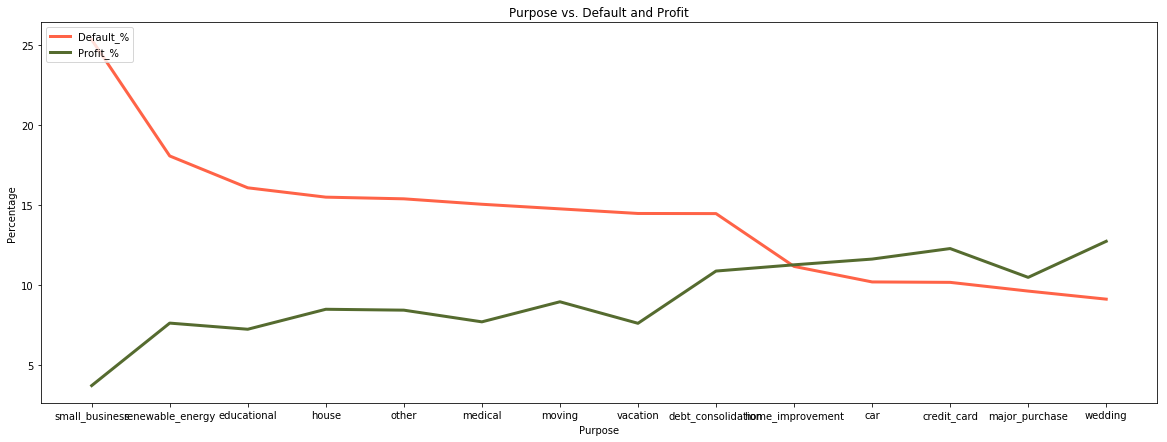

In [47]:
loan_status_by_purpose = df.groupby(['loan_status', 'purpose']).size().reset_index().pivot(columns='loan_status', index='purpose', values=0)

purpose_profit = pd.DataFrame(df.groupby('purpose')['Profit_%'].mean().sort_values())
loan_status_by_purpose['Default_%'] = loan_status_by_purpose['Charged Off']*100/(loan_status_by_purpose['Current'].add(loan_status_by_purpose['Charged Off'],fill_value=0)+loan_status_by_purpose['Fully Paid'])
loan_status_by_purpose = loan_status_by_purpose.merge(purpose_profit, how='outer', left_index=True, right_index=True)
loan_status_by_purpose.sort_values(by=['Default_%', 'Profit_%'], ascending=False, inplace=True)

figure(figsize=(20,7))
plt.pyplot.title('Purpose vs. Default and Profit')
plot(loan_status_by_purpose['Default_%'], 'tomato', label='Default_%', linewidth=3.0)
plot(loan_status_by_purpose['Profit_%'], 'darkolivegreen', label='Profit_%', linewidth=3.0)
legend(loc='upper left')
plt.pyplot.xlabel('Purpose')
plt.pyplot.ylabel('Percentage')

loan_status_by_purpose

Loans for purposes like <font color=red><b>'small_business'</b></font> and <font color=red><b>'renewable_energy'</b></font> are seeing a higher percentage of <b>default</b>. On the other hand, <font color=green><b>'wedding', 'major_purchase', 'credit_card', 'car',</b></font> etc. seem to be a good choice for giving loans. Also, 'small_business' made the least amount of profit. <u>Thus, `purpose` can be a signal of Loan Default.</u>
<br> Let us now try with Address State.

            Charged Off  Current  Fully Paid  Default_%  Profit_%
addr_state                                                       
NV                101.0     18.0       359.0      21.13      5.15
TN                  2.0      NaN         8.0      20.00      5.53
AK                 15.0      2.0        60.0      19.48      8.10
SD                 11.0      2.0        48.0      18.03     10.21
FL                459.0     82.0      2177.0      16.89      8.07
            Charged Off  Current  Fully Paid  Default_%  Profit_%
addr_state                                                       
DC                 14.0      3.0       192.0       6.70     14.46
WY                  3.0      3.0        72.0       3.85     18.14
NE                  NaN      NaN         1.0        NaN     20.62
ID                  NaN      NaN         4.0        NaN     16.03
IA                  NaN      NaN         1.0        NaN     11.56


Text(0, 0.5, 'Percentage')

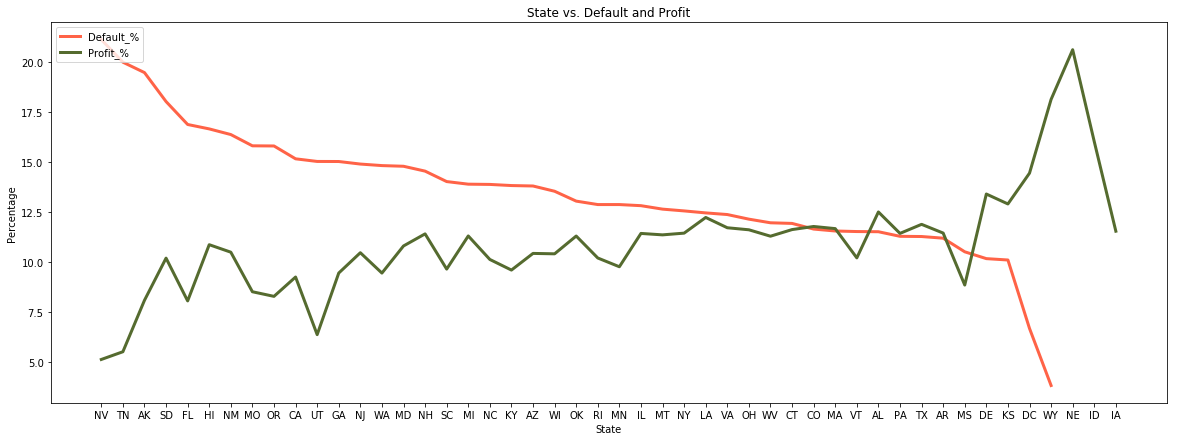

In [48]:
loan_status_by_state = df.groupby(['loan_status', 'addr_state']).size().reset_index().pivot(columns='loan_status', index='addr_state', values=0)
loan_status_by_state['Default_%'] =  loan_status_by_state['Charged Off']*100/(loan_status_by_state['Current'].add(loan_status_by_state['Charged Off'],fill_value=0).add(loan_status_by_state['Fully Paid'],fill_value=0))
address_profit = pd.DataFrame(df.groupby('addr_state')['Profit_%'].mean().sort_values())
loan_status_by_state = loan_status_by_state.merge(address_profit, how='outer', left_index=True, right_index=True)
loan_status_by_state.sort_values(by=['Default_%', 'Profit_%'], ascending=False, inplace=True)
print(loan_status_by_state.head()) # Look at state addresses with top default percentages.
print(loan_status_by_state.tail()) # Look at state addresses with lowest default percentages.

figure(figsize=(20,7))
plt.pyplot.title('State vs. Default and Profit')
plot(loan_status_by_state['Default_%'], 'tomato', label='Default_%', linewidth=3.0)
plot(loan_status_by_state['Profit_%'], 'darkolivegreen', label='Profit_%', linewidth=3.0)
legend(loc='upper left')
plt.pyplot.xlabel('State')
plt.pyplot.ylabel('Percentage')

<u>State Address is indeed showing a pattern here.</u> <font color=red><b>NEVADA, ARKANSAS, TENNESSE, etc.</b></font> seem to show higher <b>defaulting behaviour</b>. On the other hand, states like <font color=green><b>KANSAS, WYOMING, DELAWARE, WASHINGTON D.C., etc.</b></font> show higher profits and lower <b>defaulting.

In [49]:
# Regions of the US States.

West = ['AK','HI','WA','MT','OR','ID','WY','CA','NV','UT','CO']
Midwest = ['ND','MN','WI','MI','SD','IA','IL','IN','OH','NE','KS','MO']
Southeast = ['AR','LA','MS','AL','GA','FL','SC','NC','VA','WV','KY','TN','DC','MD','DE']
Southwest = ['OK','TX','AZ','NM']


def region_state(state):
    if state in West:
        return 'West'
    elif state in Midwest:
        return 'Midwest'
    elif state in Southeast:
        return 'Southeast'
    elif state in Southwest:
        return 'Southwest'
    else:
        return 'Northeast'

loan_status_by_state['region'] = loan_status_by_state.index.map(lambda x: region_state(x)) # Creating a new column.
loan_status_by_state.groupby('region').mean()

,Charged Off,Current,Fully Paid,Default_%,Profit_%
region,,,,,
Midwest,87.25,21.00,443.20,13.66,11.84
Northeast,146.62,36.00,974.88,12.66,11.07
Southeast,90.53,22.08,522.07,13.03,10.62
Southwest,118.75,27.50,828.50,13.64,11.04
West,149.70,24.50,740.73,14.63,10.44


On bucketing the states by region, minor differences of 1% are only seen. Bucketing makes state address seem insignificant. Insights were only visible when we were more granular.
<br> Debt-to-Income ratio can have impact on 'Default' of loan. Let's check that.

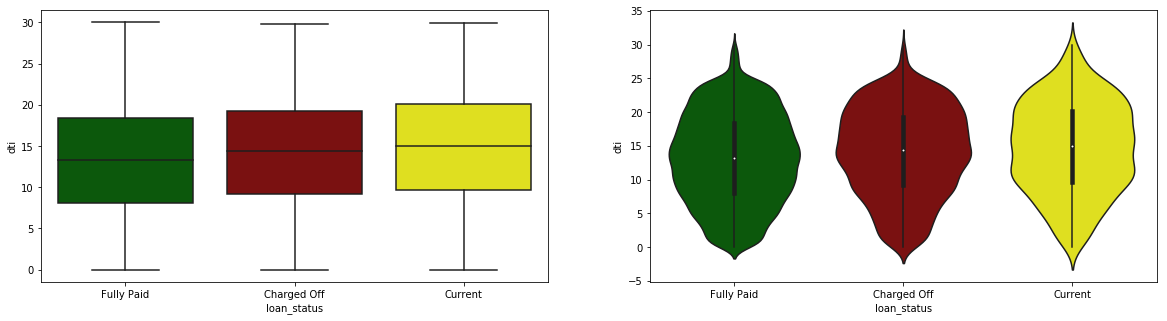

In [50]:
figure(figsize=(20,5))
subplot(121)
sns.boxplot(x="loan_status", y="dti",data=df, palette=palette)
subplot(122)
sns.violinplot(x="loan_status", y="dti",data=df, palette=palette)

Median line, 1st and 3rd quartile is <b>slightly</b> higher for 'Charged Off' status when compared with 'Fully Paid' <i>(Look at box-plot)</i>. So, it suggests that a higher debt-to-income ratio means higher chances of <b>defaulting</b>.
<br>
<i>(Look at violin-plot)</i>. For higher dti, distribution is <b>slightly</b> wider for 'Charged Off' and 'Fully Paid' status, which means that higher dti will likely show <b>default behaviour</b>. But on looking at the lower half distribution suggests us that a lower dti means more 'Fully Paid' and less 'Charged Off' status, because in the lower region 'Charged Off' status is narrower and 'Fully Paid' status is <b>slightly</b> wider. .
<br><u>But dti is not a very strong predictor. Notice how we have used the word "slightly" everywhere.</u> Also, on segmenting by other variables, very strong patterns are not seen. <i>Refer two following graphs.</i>

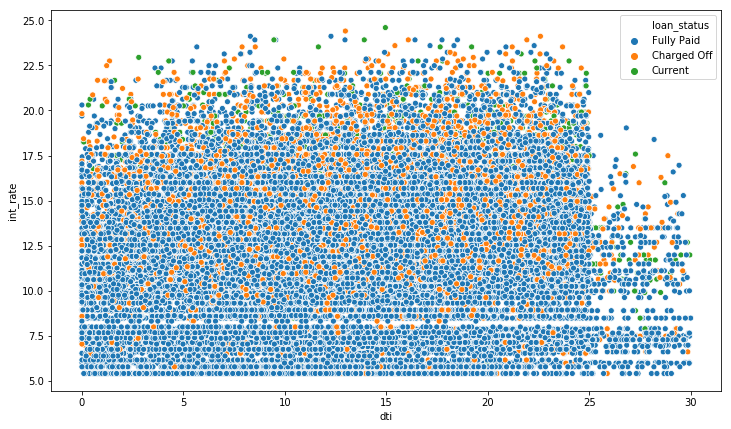

In [51]:
figure(figsize=(12,7))
sns.scatterplot(x='dti',y='int_rate',hue='loan_status',data=df)

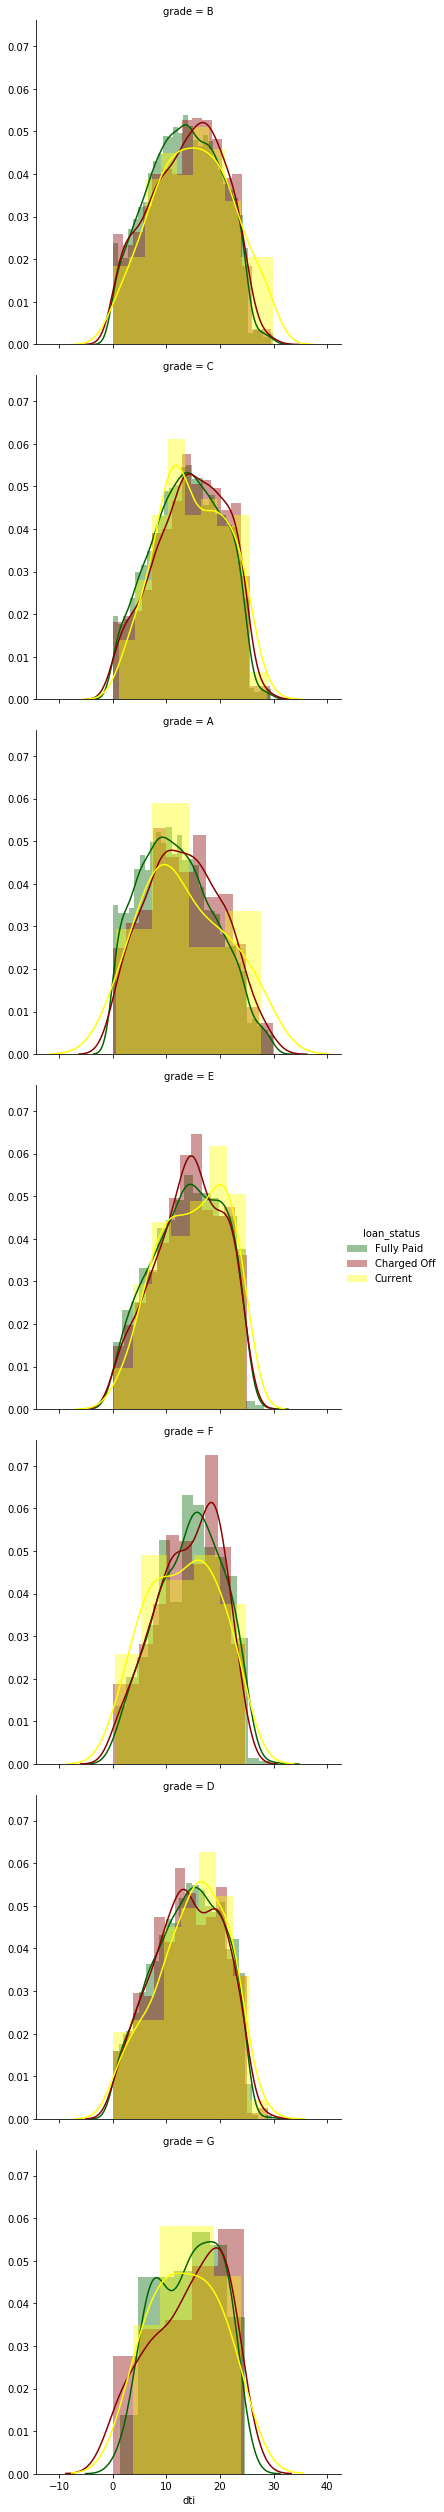

In [52]:
g = sns.FacetGrid(df, row='grade', hue="loan_status", height=5, palette=palette)
g = g.map(sns.distplot, "dti").add_legend()

Let us check `term` vs. `loan_status` now.

loan_status  Charged Off  Current  Fully Paid  Default_%
term                                                    
 36 months        2894.0      NaN     24595.0      10.53
 60 months        2307.0   1098.0      6929.0      22.32


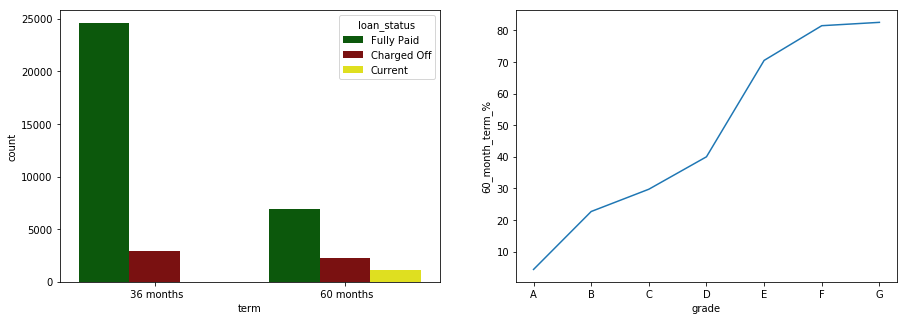

In [53]:
loan_status_by_term = df.groupby(['loan_status', 'term']).size().reset_index().pivot(columns='loan_status', index='term' , values=0)
loan_status_by_term['Default_%'] =  loan_status_by_term['Charged Off']*100/(loan_status_by_term['Current'].add(loan_status_by_term['Charged Off'],fill_value=0)+loan_status_by_term['Fully Paid'])
print(loan_status_by_term)

figure(figsize=(15,5))
subplot(121)
sns.countplot(x='term', hue='loan_status', data=df, palette=palette)

grade_by_term = df.groupby(['grade', 'term']).size().reset_index().pivot(columns='term', index='grade', values=0)
# Column that stores percentage share of grade that 60 month term has.
grade_by_term['60_month_term_%'] =  grade_by_term[' 60 months']*100/(grade_by_term[' 60 months']+grade_by_term[' 36 months'])

subplot(122)
sns.lineplot(x=grade_by_term.index, y='60_month_term_%', data=grade_by_term)

The table above shows that <u>60 months term has higher chances of <b>defaulting</b>.</u> The reason seems that, 60 months term is essentially related with grade. Higher share of poor grades like D,E,F,G are associated with 60 month term.

0.28187157413318253


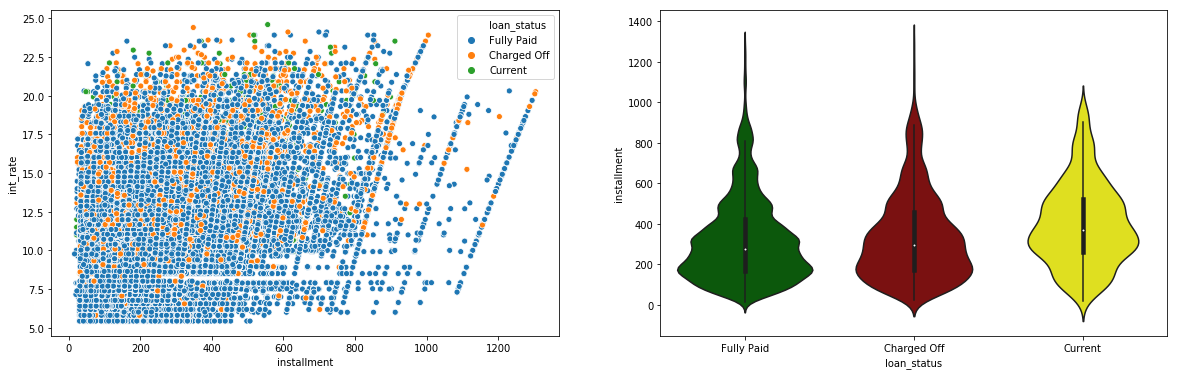

In [54]:
figure(figsize=(20,6))
subplot(121)
sns.scatterplot(x='installment', y='int_rate', data=df, hue='loan_status')
subplot(122)
sns.violinplot(y='installment', x='loan_status', data=df, palette=palette)

print(df['installment'].corr(df['int_rate'])) # correlation between interest rate and installment.

Correlation between installment and interest rate is only 28%. If this number was higher we might have thought that installment is also related to defaulting behaviour (as, interest rate is). Upon seeing the distribution in violin-plot, our belief is reinforced that installment and <b>defaulting behaviour</b> are not related.
<br>Let us see zip code's relation with <b>defaulting behaviour.

Index(['935'], dtype='object', name='zip_code')

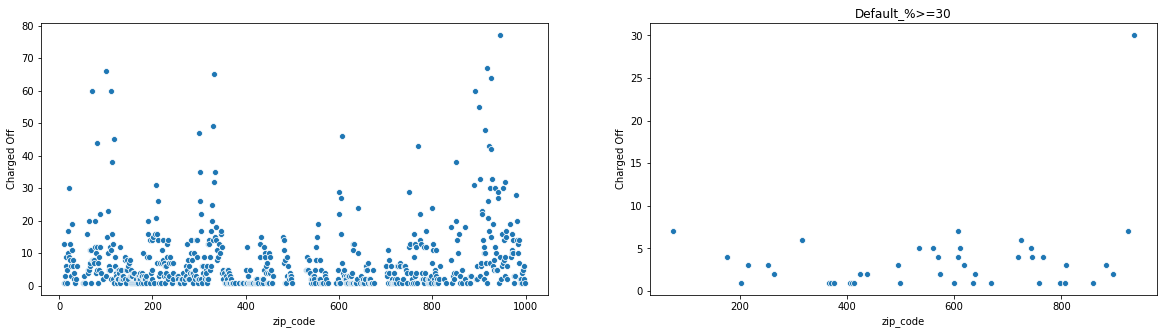

In [55]:
df['zip_code'] = df['zip_code'].str.rstrip('xx') # Modifying existing column. Removing 'xx' from the zip_code.

loan_status_by_zip = df.groupby(['loan_status', 'zip_code']).size().reset_index().pivot(columns='loan_status', index='zip_code', values=0)
loan_status_by_zip['Default_%'] = loan_status_by_zip['Charged Off']*100/(loan_status_by_zip['Current'].add(loan_status_by_zip['Charged Off'],fill_value=0)+loan_status_by_zip['Fully Paid'])

figure(figsize=(20,5))
subplot(121)
sns.scatterplot(x=loan_status_by_zip.index.astype('int64'), y=loan_status_by_zip['Charged Off'])
# Creating a new dataframe which only has rows where default percent is more than 30%.
default_gr_30 = loan_status_by_zip[loan_status_by_zip['Default_%']>=30]
subplot(122)
plt.pyplot.title('Default_%>=30')
sns.scatterplot(x=default_gr_30.index.astype('int64'), y=default_gr_30['Charged Off'])
default_gr_30.index.astype('int64')
# One particular value that stands out in the  top right of second graph.
default_gr_30[default_gr_30['Charged Off'] == default_gr_30['Charged Off'].max()].index

It can be seen that zip codes ranging around 100, 300 and from 900 to 1000 have high number of 'Charged Off' status. We can see on he 2nd graph, that zip-code 935xx has maximum 'Charged Off' applicants. This zip-code belongs to <b>California.</b>

Let us see what percent of loan-amount is paid by applicant.

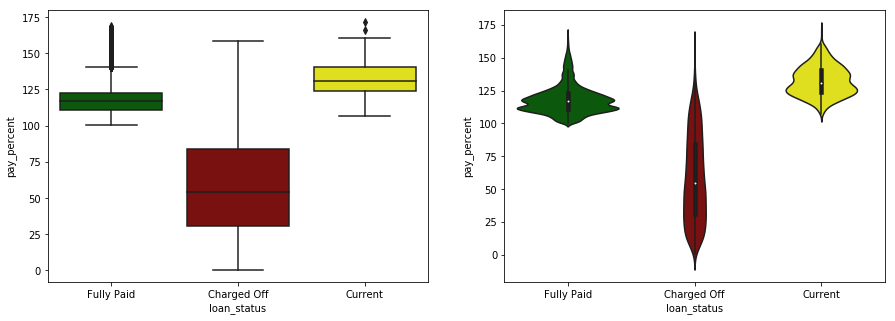

In [56]:
 # Creating our derived column that stores what percent of loan-amount is paid by applicant.
df['pay_percent']= df['total_pymnt']*100/df['funded_amnt']

# Plotting box-plot and violin-plot.
figure(figsize=(15,5))
subplot(121)
sns.boxplot(x="loan_status", y="pay_percent",data=df, palette=palette)
subplot(122)
sns.violinplot(x="loan_status", y="pay_percent",data=df, palette=palette)

<i>(See Box-plot.)</i> Median line of 'Charged Off' status suggests that, applicants who <b>default</b> are able to pay <u>half</u> of what they took. <i>(See Violin-plot.)</i> Distribution of 'Fully Paid' status suggests that around 125-100=25% more amount is paid on loan as interest.
<br>Let  us now see pubic recorded bankruptcies vs. loan status.

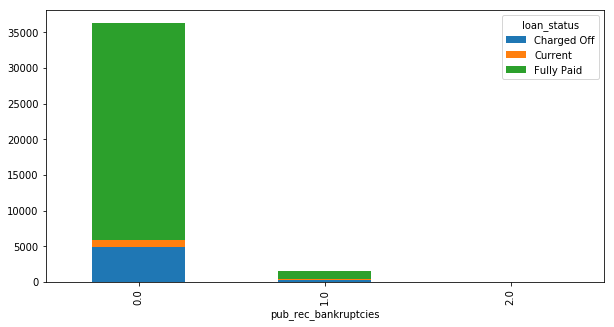

In [57]:
loan_status_by_br= df.groupby(['loan_status', 'pub_rec_bankruptcies']).size().reset_index().pivot(columns='loan_status', index='pub_rec_bankruptcies' , values=0)

# Plotting stacked-graph of public record bankruptcies and it's count with categorization of loan_status.  
loan_status_by_br.plot(kind='bar', stacked=True, figsize=(10,5))

Text(0, 0.5, 'Default Percentage')

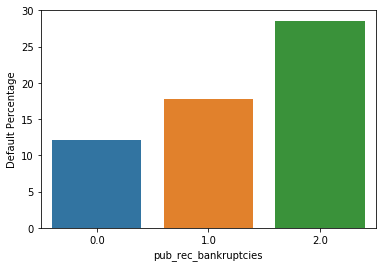

In [58]:
loan_status_by_br['Default_%'] =  loan_status_by_br['Charged Off']*100/(loan_status_by_br['Charged Off'].add(loan_status_by_br['Charged Off'],fill_value=0)+loan_status_by_br['Fully Paid'])

# Plotting barplot of number of public recorded bankruptcies vs. default percentage.
sns.barplot(x=loan_status_by_br.index, y='Default_%', data=loan_status_by_br)
plt.pyplot.xlabel('pub_rec_bankruptcies')
plt.pyplot.ylabel('Default Percentage')

First graph shows us the skewness of data. We have a lot of applicants with no recorded bankruptcies, which is reasonable and preferred. Second graph shows us that people with <b>no</b> public recorded bankruptcies tend to have lower <b>default</b> rate.
<br><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

In [59]:
# Importing clean data to csv file.

df.to_csv('df_cleaned.csv', encoding='utf-8', index=False)